# Linear models with CNN features

In [1]:
%matplotlib inline
import sys; sys.path.append('utils/')
# original lesson has imports from utility file
# however since this is instructive, want to import as I go

## Linear models in keras

Here we are just creating a simple one layer net to simulate a linear model on a synthetic response. We create a rv with shape (30,2) from normal distribution then create a response variable from the equation $y = 3x_{1} + 2x_{2} + 1$. This creates a simulated response and then we will fit the simple keras model to hopefully recreate the equation.

In [2]:
import numpy as np
from numpy.random import random

x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.

In [3]:
x[:5]

array([[ 0.27582809,  0.69759563],
       [ 0.44726207,  0.09058844],
       [ 0.59920436,  0.38189921],
       [ 0.92962417,  0.19368013],
       [ 0.72132162,  0.5495389 ]])

In [4]:
y[:5]

array([ 3.64444307,  2.16628947,  3.34410636,  3.44028874,  4.09125994])

Now we build our simple onelayer model in keras

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

lm = Sequential([ Dense(1, input_shape=(2,)) ])
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

Using Theano backend.


In [6]:
lm.evaluate(x, y, verbose=0) # this is the base MSE that we will be optimizing on

7.7707195281982422

Calling fit on our simple model runs gradient descent to fit the model

In [7]:
lm.fit(x, y, nb_epoch=5, batch_size=1) # fit runs sgd

Epoch 1/5
30/30 [==============================] - 0s - loss: 0.6180     
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.0459     
Epoch 3/5
30/30 [==============================] - 0s - loss: 0.0253     
Epoch 4/5
30/30 [==============================] - 0s - loss: 0.0111     
Epoch 5/5
30/30 [==============================] - 0s - loss: 0.0070     


In [8]:
lm.evaluate(x, y, verbose=0) # evaluate the model fit after SGD

0.0048910630866885185

We see that the MSE decreased to a very small value. Lets look at the values of our weights and see if they match the weights that we chose originally.

In [9]:
lm.get_weights()

[array([[ 1.79840004],
        [ 2.80427098]], dtype=float32), array([ 1.19100869], dtype=float32)]

We can see the weights did a good job of approximating our initial equation just after 5 epochs (5 runs throught the training data). Here is a good time to evaluate how keras is storing weights. The `model.get_weights()` function is a way to get the weights from a keras model. Here we can see that it returns an array of shape (1,2) and that array contains a matrix in the first column that has our lm weights and our bias term. This generalizez to larger NN models and will return a matrix of (num_layers, 2) each with a weight matrix and a bias.

## Train linear model on predictions

Using a Dense() layer in this way, we can easily convert the 1,000 predictions given by our model into a probability of dog vs cat--simply train a linear model to take the 1,000 predictions as input, and return dog or cat as output, learning from the Kaggle data. This should be easier and more accurate than manually creating a map from imagenet categories to one dog/cat category. 

### Training the model

We start with some basic config steps. We copy a small amount of our data into a 'sample' directory, with the exact same structure as our 'train' directory--this is *always* a good idea in *all* machine learning, since we should do all of our initial testing using a dataset small enough that we never have to wait for it.

In [10]:
import os
path = "data/redux/sample/"
# path = "data/dogscats/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

We will process as many images at a time as our graphics card allows. This is a case of trial and error to find the max batch size - the largest size that doesn't give an out of memory error.

In [11]:
# batch_size=100
batch_size=4

We need to start with our VGG 16 model, since we'll be using its predictions and features.

In [12]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Our overall approach here will be:

1. Get the true labels for every image
2. Get the 1,000 imagenet category predictions for every image
3. Feed these predictions as input to a simple linear model.

Let's start by grabbing training and validation batches.

### NOTE: always specify your target_size when using transfer learning -> when not training a NN from scratch

This is mostly for future me (yes you) , cause you will forget and you will get cryptic error messages from keras that say you're outa shape and you'll not know what is going on

Essentially what keras is doing is this:

```python
from PIL import Image

basewidth = 300
img = Image.open('somepic.jpg')
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
```
Which is just calculating what percentage the new size is of the original image and then resizing a numpy array, nothing too crazy but since you're always wondering how the hell it works, here now you wont have to google: *"how can keras magically resize images like it's not a problem"*

![loose-seal](data/lucille-portable.gif)

In [13]:
# load keras function for getting batches
from keras.preprocessing.image import ImageDataGenerator
# Use batch size of 1 since we're just doing preprocessing on the CPU
idg = ImageDataGenerator()
trn_batches = idg.flow_from_directory(path+'train',
                                      shuffle=False,
                                      batch_size=1,
                                      target_size=(224,224))
val_batches = idg.flow_from_directory(path+'valid',
                                      shuffle=False,
                                      batch_size=1,
                                      target_size=(224,224))

Found 398 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [14]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

Here we can concatenate all of the data from the batches that we loaded for training and validation

In [ ]:
val_data = np.concatenate([val_batches.next()[0] for i in range(val_batches.nb_sample)])
trn_data = np.concatenate([trn_batches.next()[0] for i in range(trn_batches.nb_sample)])

In [ ]:
trn_data.shape

In [ ]:
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

We can load our training and validation data later without recalculating them:

In [15]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [16]:
val_data.shape

(100, 3, 224, 224)

Keras returns *classes* as a single column, so we convert to one hot encoding

In [20]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [21]:
val_classes = val_batches.classes
trn_classes = trn_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [22]:
trn_labels.shape

(398, 2)

In [23]:
trn_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [24]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

...and their 1,000 imagenet probabilties from VGG16--these will be the *features* for our linear model:

In [ ]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [ ]:
save_array(model_path+'train_lastlayer_features.bc', trn_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

We can load our training and validation features later without recalculating them:

In [25]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')
trn_features.shape, val_features.shape

((398, 1000), (100, 1000))

Now we can define our linear model, just like we did earlier:

In [26]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
from keras.optimizers import RMSprop

lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

We're ready to fit the model!

In [27]:
# batch_size=64
batch_size=4

In [28]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 2)             2002        dense_input_2[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [29]:
lm.fit(trn_features, trn_labels, nb_epoch=3, 
       batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 398 samples, validate on 100 samples
Epoch 1/3
398/398 [==============================] - 0s - loss: 0.1989 - acc: 0.9397 - val_loss: 0.1507 - val_acc: 0.9500
Epoch 2/3
398/398 [==============================] - 0s - loss: 0.0926 - acc: 0.9573 - val_loss: 0.1327 - val_acc: 0.9700
Epoch 3/3
398/398 [==============================] - 0s - loss: 0.0739 - acc: 0.9648 - val_loss: 0.1332 - val_acc: 0.9500


### Viewing model prediction examples

- **Tip**: with our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still **under-fitting**!

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5)

This is going to be the standard for evaluating predictions heuristically as we are training networks. Since this is a very simple model trained on the image net predicitons, there may not be much but it is always a really good place to start

In [30]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
probs[:8]

  4/100 [>.............................] - ETA: 0s

array([ 0.99997216,  0.99999976,  1.        ,  0.99999607,  0.99999893,
        0.99997938,  0.99965781,  0.99835116], dtype=float32)

In [31]:
preds[:8]

array([0, 0, 0, 0, 0, 0, 0, 0])

Get the filenames for the validation set, so we can view images:

In [32]:
filenames = val_batches.filenames

In [33]:
# Number of images to view for each visualization task
n_view = 4

Helper function to plot images by index in the validation set: loaded so u know where they're from

In [42]:
sys.path.append('utils/')
from keras.preprocessing import image
from utils import plots
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

Lets walk throught the examples here and go through how we're selecting the the images for these line by line

```python
#to select where the prediction vector pred (the one containing probabiliy cat) is equal to the validation labels y second column or cat
correct = np.where(preds==val_labels[:,1])[0]

#randomly permute the correct responses and grab however many specified by n_view
idx = permutation(correct)[:n_view]

#plot_idx is defined abouve, and it's just simply loading the image with the file name specified by the idx 
plots_idx(idx, probs[idx])
```

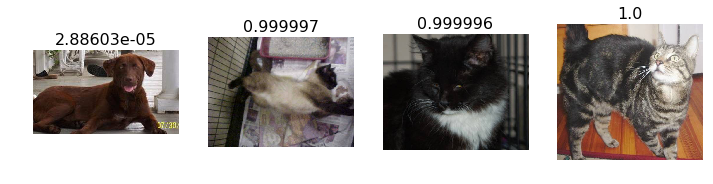

In [43]:
#1. A few correct labels at random
from numpy.random import permutation
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

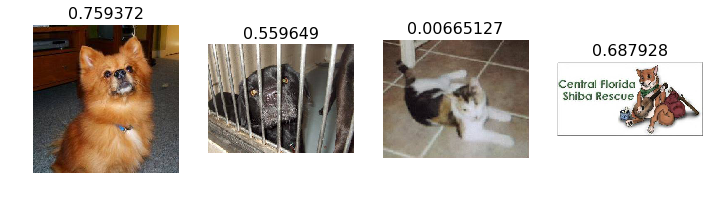

In [44]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

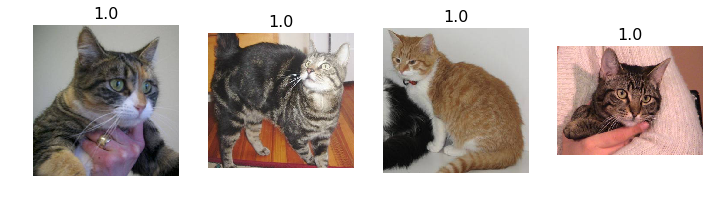

In [45]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

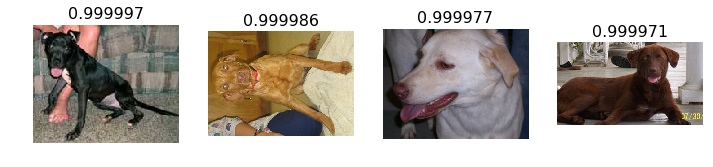

In [46]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

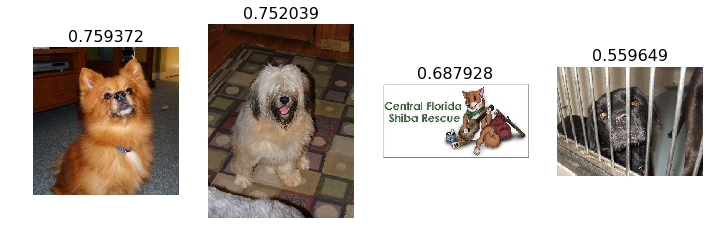

In [47]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

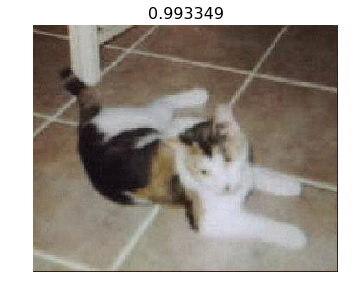

In [48]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1-probs[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

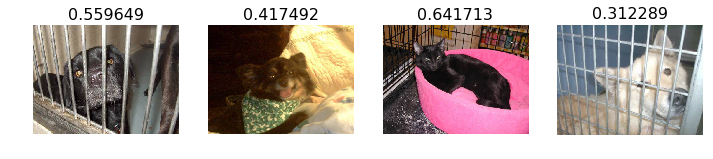

In [49]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_classes, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[48  1]
 [ 4 47]]


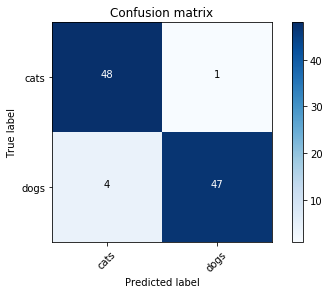

In [53]:
from utils import plot_confusion_matrix
plot_confusion_matrix(cm, val_batches.class_indices)

### About activation functions

So below is the definition of a few of our layers for our keras model. We can see that one of the things we are doing is setting the argument in `Dense()` called activation.
```python
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])

model.add(Dense(4096, activation='relu'))
```

Activations are pretty much THE important thing  in Deep Learning. There are alot of articles that talk about activations but I'm going to try to explain *universality* from 1000 ft. I.E. in a way that you can understand even if ur not a math person. Essentially every layer of a neural net is a linear transform, much like the simple linear regression we did at the begining of this network. If we just used linear layers, multiplying throught a network, we would only be able to fit a linear function. The linear layers are made non-linear using, yeah u gessed it, *activation functions*!

These make each layer go throught some kind of transform, esentially putting similar values close to each other and dissimilar values on opposite sides, but all on a relative scale. This does so many things that make deep learning possibly but we can just use the plots of the main activations below to explain what I mean. **Not a proof** so get lost to [here](http://neuralnetworksanddeeplearning.com/chap4.html) if thats what you want.

sigmoid:
![sigmoid](data/logistic.png)

so you can see that for all the values of X which are the values of the weights at each node, the sigmoid function will put them on a scale of [0,1] with positive $x_{pos} \in (0.5,1]$ and negative $x_{neg} \in [0, 0.5)$. So all the activations do something similar, but we want to use ones that avoid blowing up or getting too small when we take their derivative which sigmoid can do. Here are more examples:

tanh:
![tanh](data/tanh.png)

relu:
![relu](data/relu.jpeg)

leaky-relu:
![leaky](data/leaky.png)

For converting probabilities into labels, we will use a softmax function. The softmax function aproximates the hardmax or max or max function

We will see other activation functions later in this course - but relu (and minor variations) for intermediate layers and softmax for output layers will be by far the most common.

# Modifying the model

## Retrain last layer's linear model

Since the original VGG16 network's last layer is Dense (i.e. a linear model) it seems a little odd that we are adding an additional linear model on top of it. This is especially true since the last layer had a softmax activation, which is an odd choice for an intermediate layer--and by adding an extra layer on top of it, we have made it an intermediate layer. What if we just removed the original final layer and replaced it with one that we train for the purpose of distinguishing cats and dogs? It turns out that this is a good idea - as we'll see!

We start by removing the last layer, and telling Keras that we want to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).

In [54]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [55]:
model.pop()
for layer in model.layers: layer.trainable=False

**Careful!** Now that we've modified the definition of *model*, be careful not to rerun any code in the previous sections, without first recreating the model from scratch! (Yes, I made that mistake myself, which is why I'm warning you about it now...)

Now we're ready to add our new final layer...

In [56]:
model.add(Dense(2, activation='softmax'))

In [57]:
??vgg.finetune

...and compile our updated model, and set up our batches to use the preprocessed images (note that now we will also *shuffle* the training batches, to add more randomness when using multiple epochs):

In [58]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

We'll define a simple function for fitting models, just to save a little typing...

In [59]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.n, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.n)

...and now we can use it to train the last layer of our model!

(It runs quite slowly, since it still has to calculate all the previous layers in order to know what input to pass to the new final layer. We could precalculate the output of the penultimate layer, like we did for the final layer earlier - but since we're only likely to want one or two iterations, it's easier to follow this alternative approach.)

In [60]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
398/398 [==============================] - 256s - loss: 8.9295 - acc: 0.4422 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/2
398/398 [==============================] - 313s - loss: 8.7475 - acc: 0.4573 - val_loss: 7.6167 - val_acc: 0.5200


So obv we don't do so great since we've ran this on a total 300 images twice using a batch size of 4 on my cpu, but previous lessons show you can run this on a gpu like 5 times and get 98% acc.

This section really shows why we use keras, because it's like all of 5 lines of code to get a good model up and running that works. Yeah for advanced stuffs u need to peer deep down into your tensors, but usually u want to start with something that works well quickly, so that is what keras is for.

It's smart to save weights but we won't because these are bad and I have good ones from a gpu run I've done previously!

In [ ]:
model.save_weights(model_path+'finetune1.h5')

In [64]:
model_wt_path = 'data/redux/results/'
model.load_weights(model_wt_path+'ft2.h5')

In [65]:
model.evaluate(val_data, val_labels)

100/100 [==============================] - 67s    


[0.62537365436554471, 0.95999999999999996]

We can look at the earlier prediction examples visualizations by redefining *probs* and *preds* and re-using our earlier code.

In [ ]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

In [ ]:
cm = confusion_matrix(val_classes, preds)

In [ ]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## Retraining more layers

Now that we've fine-tuned the new final layer, can we, and should we, fine-tune *all* the dense layers? The answer to both questions, it turns out, is: yes! Let's start with the "can we" question...

### Training multiple layers in Keras

The code below will work on any model that contains dense layers; it's not just for this VGG model.

NB: Don't skip the step of fine-tuning just the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized imagenet weights.

In [ ]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

Since we haven't changed our architecture, there's no need to re-compile the model - instead, we just set the learning rate. Since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously.

In [ ]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

This is an extraordinarily powerful 5 lines of code. We have fine-tuned all of our dense layers to be optimized for our specific data set. This kind of technique has only become accessible in the last year or two - and we can already do it in just 5 lines of python!

In [ ]:
model.save_weights(model_path+'finetune2.h5')

There's generally little room for improvement in training the convolutional layers, if you're using the model on natural images (as we are). However, there's no harm trying a few of the later conv layers, since it may give a slight improvement, and can't hurt (and we can always load the previous weights if the accuracy decreases).

In [ ]:
for layer in layers[12:]: layer.trainable=True
K.set_value(opt.lr, 0.001)

In [ ]:
fit_model(model, batches, val_batches, 4)

In [ ]:
model.save_weights(model_path+'finetune3.h5')

You can always load the weights later and use the model to do whatever you need:

In [ ]:
model.load_weights(model_path+'finetune2.h5')
model.evaluate_generator(get_batches(path+'valid', gen, False, batch_size*2), val_batches.n)